<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Полезные-ссылки:" data-toc-modified-id="Полезные-ссылки:-0.0.1"><span class="toc-item-num">0.0.1&nbsp;&nbsp;</span><font color="orange">Полезные ссылки:</font></a></span></li></ul></li><li><span><a href="#Общее-впечатление" data-toc-modified-id="Общее-впечатление-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span><font color="orange">Общее впечатление</font></a></span></li><li><span><a href="#Общее-впечатление-(ревью-2)" data-toc-modified-id="Общее-впечатление-(ревью-2)-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span><font color="orange">Общее впечатление (ревью 2)</font></a></span></li><li><span><a href="#Общее-впечатление-(ревью-3)" data-toc-modified-id="Общее-впечатление-(ревью-3)-0.3"><span class="toc-item-num">0.3&nbsp;&nbsp;</span><font color="orange">Общее впечатление (ревью 3)</font></a></span></li><li><span><a href="#Общее-впечатление-(ревью-4)" data-toc-modified-id="Общее-впечатление-(ревью-4)-0.4"><span class="toc-item-num">0.4&nbsp;&nbsp;</span><font color="orange">Общее впечатление (ревью 4)</font></a></span></li></ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [ ]:
taxis = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [ ]:
taxis.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [ ]:
print(taxis.index.is_monotonic)

True


In [ ]:
taxis.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [ ]:
taxis = taxis.resample('1H').sum()

In [ ]:
taxis.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


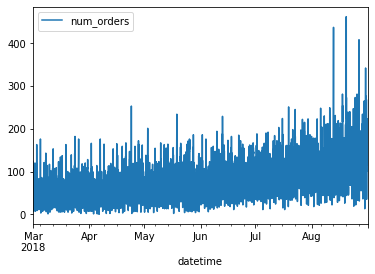

In [ ]:
taxis.plot()
plt.show()

Судя по графику временной ряд нестационарный, у него меняется среднее значение

## Анализ

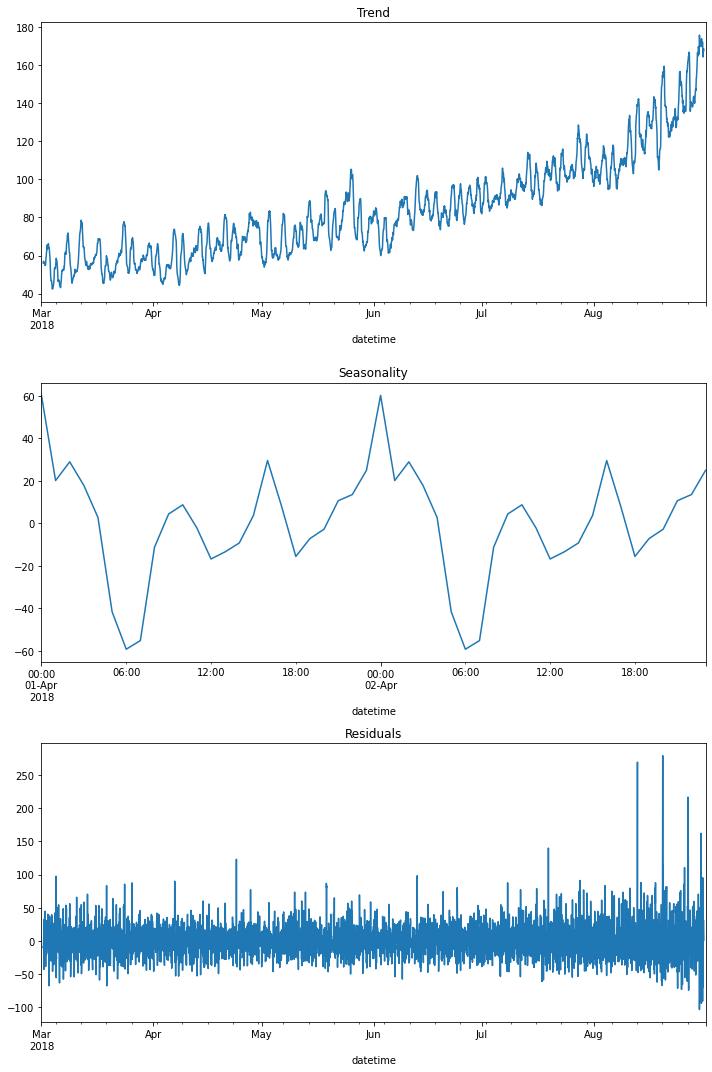

In [ ]:
decompose = seasonal_decompose(taxis)

plt.figure(figsize=(10,15))
plt.subplot(311)

decompose.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decompose.seasonal['2018-04-01':'2018-04-02'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decompose.resid.plot(ax=plt.gca())
plt.title('Residuals')


plt.tight_layout()





In [ ]:
taxis['rolling_mean'] = taxis.rolling(7).mean()

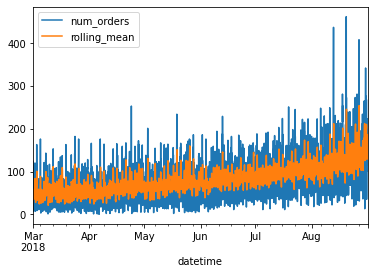

In [ ]:
taxis.plot()
plt.show()

**Мини вывод**

Тренд показывает, что кол-во заказов увеличивается, сезонность за день - после 18 часов спрос на такси растет, люди начинают возврааться с работы, к полуночи достагается пик, т.к. скорее всего из-за того, что общественный транспорт ходит реже, либо не ходит уже вообще. Временной ряд нестационарный.

## Обучение

**Напишем функцию make_features, чтобы прибавить к таблице 4 новых признака: год, месяц, дата, день день недели**

In [ ]:
df = taxis.copy()
def make_features (df, max_lag, rolling_mean_size):
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek

    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    return df
make_features(df, 400, 300)
df.shape

(4416, 406)

In [ ]:
df.head()

,num_orders,rolling_mean,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,...,lag_391,lag_392,lag_393,lag_394,lag_395,lag_396,lag_397,lag_398,lag_399,lag_400
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,2018,3,1,3,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,2018,3,1,3,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,2018,3,1,3,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,NaN,2018,3,1,3,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,NaN,2018,3,1,3,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Для дальнейшего беспроблемного обучения моделей, избавимся от пропусков**

In [ ]:
df = df.dropna()

**Разделим выборку на обучающую и тестовую, размер тестовой - 10% от исходных данных.

In [ ]:
train, test = train_test_split(df, shuffle = False, test_size=0.1)

In [ ]:
train_features = train.drop(['num_orders'], axis =1)
train_target = train['num_orders']
test_features = test.drop(['num_orders'], axis =1)
test_target = test['num_orders']

**Создадим кросс валидационную модель**

In [ ]:
cv = KFold(random_state= 12345, n_splits=3, shuffle = True)

**Обучим модель линейной регрессии и посчитаем метрику rmse**

In [ ]:
lin = LinearRegression()
params = {}
lin_grid = RandomizedSearchCV(lin, params, scoring = 'neg_mean_squared_error', cv=TimeSeriesSplit(), verbose = 1, n_jobs=-1)
lin_grid.fit(train_features, train_target)
pred_lin_cv = lin_grid.predict(train_features)
print('RMSE Линейной регрессии', rmse_lin)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
RMSE Линейной регрессии 5.140319674825207


**LightGBM**

In [ ]:
%%time
lgbm = LGBMRegressor(num_leaves = 30, learning_rate = 0.01)

lgbm_params = {'n_estimators': [10, 160, 15],
              'max_depth': [2, 12, 2]
}



lgbm_grid = GridSearchCV(lgbm, lgbm_params, scoring = 'neg_mean_squared_error', verbose = True, cv=TimeSeriesSplit())

lgbm_grid.fit(train_features, train_target)
rmse_lgbm = np.sqrt(-1*lgbm_grid.best_score_)
print(lgbm_grid.best_params_)
print(rmse_lgbm)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
{'max_depth': 12, 'n_estimators': 160}
25.209872714334498
CPU times: user 18min 32s, sys: 10.9 s, total: 18min 42s
Wall time: 18min 52s


Метрика RMSE у модели LightGBM составляет 23,1

**CatBoost**

In [ ]:
%%time
model_cat = CatBoostRegressor(learning_rate = 0.01, loss_function = 'RMSE')

params_cat = {'iterations': [10, 20],
             'max_depth':[2,12, 2]
}

grid_cat = GridSearchCV(model_cat, params_cat, cv=TimeSeriesSplit(), scoring='neg_mean_squared_error', verbose = 10)

grid_cat.fit(train_features, train_target)
rmse_grid_cat = np.sqrt(-1*grid_cat.best_score_)
print(grid_cat.best_params_)
print(rmse_grid_cat)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START iterations=10, max_depth=2..................................
0:	learn: 29.0397265	total: 56.8ms	remaining: 511ms
1:	learn: 28.9261408	total: 64.1ms	remaining: 256ms
2:	learn: 28.8209494	total: 70.2ms	remaining: 164ms
3:	learn: 28.7110917	total: 76.7ms	remaining: 115ms
4:	learn: 28.6135021	total: 83ms	remaining: 83ms
5:	learn: 28.5044839	total: 89.5ms	remaining: 59.6ms
6:	learn: 28.4027468	total: 96.4ms	remaining: 41.3ms
7:	learn: 28.3143292	total: 103ms	remaining: 25.6ms
8:	learn: 28.2087950	total: 109ms	remaining: 12.1ms
9:	learn: 28.1081239	total: 116ms	remaining: 0us
[CV 1/5; 1/6] END ................iterations=10, max_depth=2; total time=   1.1s
[CV 2/5; 1/6] START iterations=10, max_depth=2..................................
0:	learn: 31.1690586	total: 9.57ms	remaining: 86.1ms
1:	learn: 31.0571157	total: 17.8ms	remaining: 71.2ms
2:	learn: 30.9242213	total: 25.6ms	remaining: 59.8ms
3:	learn: 30.7964643	t

У модели CatBoost RMSE = 39,37

Лучшей моделью на кросс валидационной моделе  стала модель линейной регрессии, с метрикой RMSE 5,14. Проверим ее на тестовой выборке

## Тестирование

In [ ]:
pred_test_lin = lin_grid.predict(test_features)
rmse_lin_test = mean_squared_error(test_target, pred_test_lin)**0.5
print(rmse_lin_test)

36.30767644861311


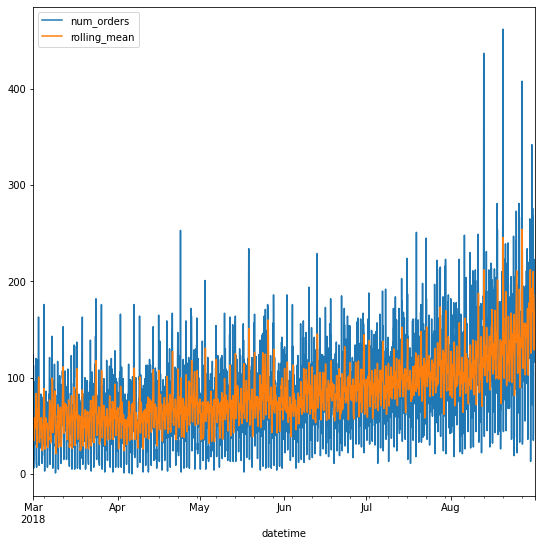

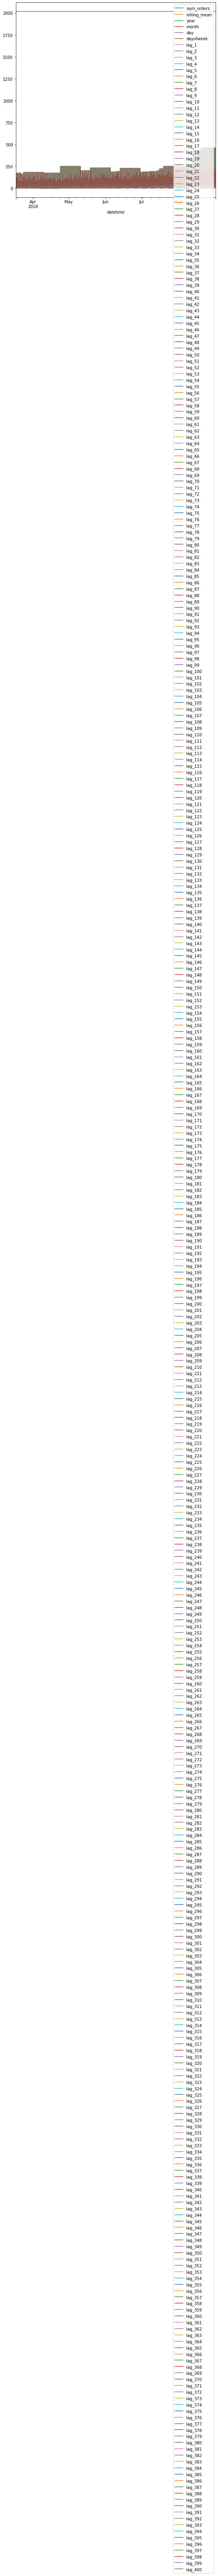

In [ ]:
taxis.plot(figsize=(9, 9))
df.plot(figsize=(9,9))
plt.show()

**На графике предсказанного ряда, видно, что он стал более похож на стационарный.**

**Вывод**

**Лучшей моделью при проверке на тестовой выборке стала модель линейной регрессии с показателем RMSE 36.3, что не превышает указанного значения в задании 48.**